In [1]:
"""
Linear Regression 
Assignment 38

1. PREDICTING HOUSE SALES
Predict final sales of house of residential homes in King Country, US. using Linear Regression Algorithm. Compare their results using Regression Metrics. Make new predictions using model with best fit R2_Score
(R2_Sccore, MSE, RMSE, MAE)
Dataset Link: 
https://raw.githubusercontent.com/ammishra08/MachineLearning/master/Datasets/house_sales_data.csv

2. PREDICTING MEDICAL INSURANCE COST
Medical Insurance cost Exploratory Analysis with interesting insights of data using various visualization and making predictions using Regressor. Evaluate results using Regression Metrics. Make new predictions on Testing Samples
(R2_Score, MSE, RMSE, MAE)
Target Column: charges
Dataset Link:
https://raw.githubusercontent.com/ammishra08/MachineLearning/master/Datasets/insurance.csv

3. PREDICTING AUTOMOBILE AVERAGE
MPG exploratory analysis with interesting insights using various visualization and making predictions using Linear Regression Algorithm. Evaluate results using Regression Metrics. Make new predictions on Testing Samples
(R2_Score, MSE, RMSE, MAE)
Dataset Link:
https://raw.githubusercontent.com/ammishra08/MachineLearning/master/Datasets/auto-mpg.data
Column Names: https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.names


"""

'\nLinear Regression \nAssignment 38\n\n1. PREDICTING HOUSE SALES\nPredict final sales of house of residential homes in King Country, US. using Linear Regression Algorithm. Compare their results using Regression Metrics. Make new predictions using model with best fit R2_Score\n(R2_Sccore, MSE, RMSE, MAE)\nDataset Link: \nhttps://raw.githubusercontent.com/ammishra08/MachineLearning/master/Datasets/house_sales_data.csv\n\n2. PREDICTING MEDICAL INSURANCE COST\nMedical Insurance cost Exploratory Analysis with interesting insights of data using various visualization and making predictions using Regressor. Evaluate results using Regression Metrics. Make new predictions on Testing Samples\n(R2_Score, MSE, RMSE, MAE)\nTarget Column: charges\nDataset Link:\nhttps://raw.githubusercontent.com/ammishra08/MachineLearning/master/Datasets/insurance.csv\n\n3. PREDICTING AUTOMOBILE AVERAGE\nMPG exploratory analysis with interesting insights using various visualization and making predictions using Linea

In [2]:
try:
    sc.stop()
except:
    print('no sc to stop')

In [93]:
# some imports may repeat for modularity inside ipynb

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession 

from pyspark.sql.types import StructField, StringType, IntegerType, StructType
from pyspark.mllib.stat import Statistics 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [94]:
from pyspark.mllib.stat import Statistics

def compute_corr_matrix(df, 
                        method = 'pearson', # -->npfor 
                        exclude_types=['string', 'date']):
    """
    expects pyspark df returns pandas df
    function by Emy based on Amit & Dongli instruction
    """
    cols_=[k for k,v in df.dtypes if v not in exclude_types] # exclude types is currently given, could be done programmatically
    
    df_rdd = df.select(*cols_).rdd.map( lambda r: r[0:] ) # collect df as rdd via df.map() call
    
    corr_mat = Statistics.corr(df_rdd, method=method) # pyspark.mllib.stat.Statistics.corr # correlation matrix
    
    corr_mat_df = pd.DataFrame(corr_mat, columns=cols_, index=cols_)
    
    return(corr_mat_df)

In [4]:
conf = SparkConf().setAppName('hw38').setMaster('local[4]')
sc = SparkContext.getOrCreate(conf = conf)

spark = SparkSession.builder.appName('hw38').getOrCreate()
sc

<SparkContext master=local[4] appName=hw38>

In [5]:
housing_data_path = "/home/hadoop/data/house_sales_data.csv"

df = spark.read.csv("file://{}".format(housing_data_path), inferSchema=True, header=True)

In [6]:
df.schema, df.columns

(StructType(List(StructField(id,LongType,true),StructField(date,StringType,true),StructField(price,DecimalType(7,0),true),StructField(bedrooms,IntegerType,true),StructField(bathrooms,DoubleType,true),StructField(sqft_living,IntegerType,true),StructField(sqft_lot,IntegerType,true),StructField(floors,DoubleType,true),StructField(waterfront,IntegerType,true),StructField(view,IntegerType,true),StructField(condition,IntegerType,true),StructField(grade,IntegerType,true),StructField(sqft_above,IntegerType,true),StructField(sqft_basement,IntegerType,true),StructField(yr_built,IntegerType,true),StructField(yr_renovated,IntegerType,true),StructField(zipcode,IntegerType,true),StructField(lat,DoubleType,true),StructField(long,DoubleType,true),StructField(sqft_living15,IntegerType,true),StructField(sqft_lot15,IntegerType,true))),
 ['id',
  'date',
  'price',
  'bedrooms',
  'bathrooms',
  'sqft_living',
  'sqft_lot',
  'floors',
  'waterfront',
  'view',
  'condition',
  'grade',
  'sqft_above',
  

In [7]:
df.printSchema()

root
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- price: decimal(7,0) (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: double (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_above: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- yr_built: integer (nullable = true)
 |-- yr_renovated: integer (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)



In [8]:
from pyspark.sql.functions import to_date
from pyspark.sql.functions import when

df = df.withColumn("date_d", to_date(df.date, 'yyyyMMdd'))
df.select('date').take(5)

[Row(date='20141013T000000'),
 Row(date='20141209T000000'),
 Row(date='20150225T000000'),
 Row(date='20141209T000000'),
 Row(date='20150218T000000')]

In [9]:
[(k,v) for k,v in df.dtypes if v !='string99']

[('id', 'bigint'),
 ('date', 'string'),
 ('price', 'decimal(7,0)'),
 ('bedrooms', 'int'),
 ('bathrooms', 'double'),
 ('sqft_living', 'int'),
 ('sqft_lot', 'int'),
 ('floors', 'double'),
 ('waterfront', 'int'),
 ('view', 'int'),
 ('condition', 'int'),
 ('grade', 'int'),
 ('sqft_above', 'int'),
 ('sqft_basement', 'int'),
 ('yr_built', 'int'),
 ('yr_renovated', 'int'),
 ('zipcode', 'int'),
 ('lat', 'double'),
 ('long', 'double'),
 ('sqft_living15', 'int'),
 ('sqft_lot15', 'int'),
 ('date_d', 'date')]

In [10]:
df = df.drop('date')
df = df.withColumnRenamed('date_d', 'date')

In [12]:
6

# cols_=[k for k,v in df.dtypes if v !='string']
# df_rdd = df.rdd.map( lambda r: r[0:] )
# corr_mat = Statistics.corr(df_rdd, method='pearson')
# corr_mat_df = pd.DataFrame(corr_mat, columns=cols_, index=cols_)

In [13]:
C_M = compute_corr_matrix(df)
C_M

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.016762,0.001286,0.005160,-0.012258,-0.132109,0.018525,-0.002721,0.011592,-0.023783,0.008130,-0.010842,-0.005151,0.021380,-0.016907,-0.008224,-0.001891,0.020799,-0.002901,-0.138798
price,-0.016762,1.000000,0.308350,0.525138,0.702035,0.089661,0.256794,0.266369,0.397293,0.036362,0.667434,0.605567,0.323816,0.054012,0.126434,-0.053203,0.307003,0.021626,0.585379,0.082447
bedrooms,0.001286,0.308350,1.000000,0.515884,0.576671,0.031703,0.175429,-0.006582,0.079532,0.028472,0.356967,0.477600,0.303093,0.154178,0.018841,-0.152668,-0.008931,0.129473,0.391638,0.029244
bathrooms,0.005160,0.525138,0.515884,1.000000,0.754665,0.087740,0.500653,0.063744,0.187737,-0.124982,0.664983,0.685342,0.283770,0.506019,0.050739,-0.203866,0.024573,0.223042,0.568634,0.087175
sqft_living,-0.012258,0.702035,0.576671,0.754665,1.000000,0.172826,0.353949,0.103818,0.284611,-0.058753,0.762704,0.876597,0.435043,0.318049,0.055363,-0.199430,0.052529,0.240223,0.756420,0.183286
sqft_lot,-0.132109,0.089661,0.031703,0.087740,0.172826,1.000000,-0.005201,0.021604,0.074710,-0.008958,0.113621,0.183512,0.015286,0.053080,0.007644,-0.129574,-0.085683,0.229521,0.144608,0.718557
floors,0.018525,0.256794,0.175429,0.500653,0.353949,-0.005201,1.000000,0.023698,0.029444,-0.263768,0.458183,0.523885,-0.245705,0.489319,0.006338,-0.059121,0.049614,0.125419,0.279885,-0.011269
waterfront,-0.002721,0.266369,-0.006582,0.063744,0.103818,0.021604,0.023698,1.000000,0.401857,0.016653,0.082775,0.072075,0.080588,-0.026161,0.092885,0.030285,-0.014274,-0.041910,0.086463,0.030703
view,0.011592,0.397293,0.079532,0.187737,0.284611,0.074710,0.029444,0.401857,1.000000,0.045990,0.251321,0.167649,0.276947,-0.053440,0.103917,0.084827,0.006157,-0.078400,0.280439,0.072575
condition,-0.023783,0.036362,0.028472,-0.124982,-0.058753,-0.008958,-0.263768,0.016653,0.045990,1.000000,-0.144674,-0.158214,0.174105,-0.361417,-0.060618,0.003026,-0.014941,-0.106500,-0.092824,-0.003406


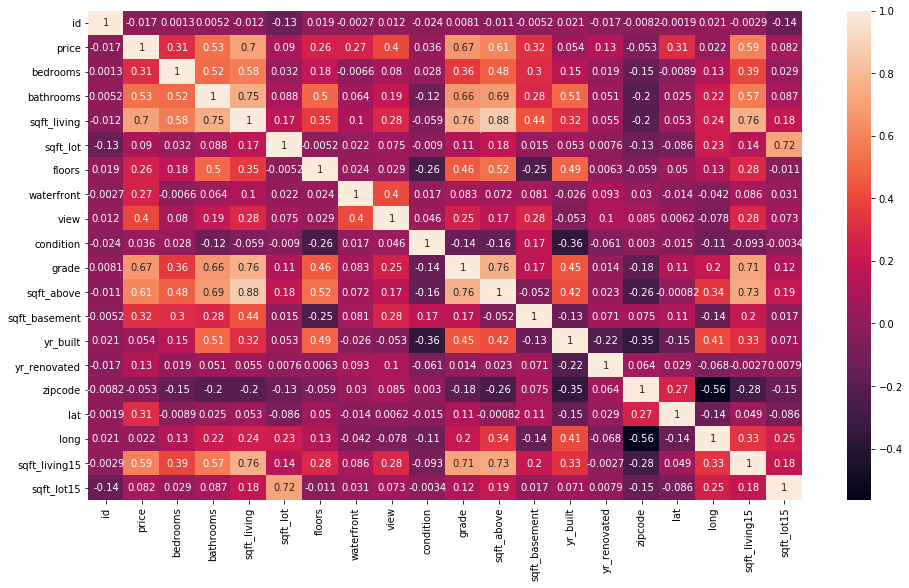

In [14]:
plt.figure(figsize=(16,9))
sns.heatmap(C_M, annot=True)

In [102]:
#flatten = lambda l: [item for sublist in l for item in sublist]
def get_multicol_cols(unstacked_cm, threshold=.8, single_col=None):
    if single_col:
        pass        
    hi0 = list(filter(lambda c: c[1] >=threshold, unstacked_cm.items()))
    lo0 = list(filter(lambda c: c[1] <=-threshold, unstacked_cm.items()))
    lo0 = list(filter(lambda c: c[0][0]!=c[0][1], unstacked_cm.items()))
    is_multicolinear = list(filter(lambda c: c[1] !=1, hi0+lo0))
    not_multicolinear = list(filter(lambda c: c not in is_multicolinear, unstacked_cm.items()))
    return(is_multicolinear, not_multicolinear)

In [101]:
(('from','to'), 0.0) # shape of each corr.unstacked.items() item

# list(C_M.unstack().items())[1]
list(C_M.unstack().items())

[(('id', 'id'), 1.0),
 (('id', 'price'), -0.016762196614446296),
 (('id', 'bedrooms'), 0.0012862772314907313),
 (('id', 'bathrooms'), 0.005160231618838044),
 (('id', 'sqft_living'), -0.01225776517250453),
 (('id', 'sqft_lot'), -0.13210870152459606),
 (('id', 'floors'), 0.01852522915416667),
 (('id', 'waterfront'), -0.002721093803985222),
 (('id', 'view'), 0.011592365491011867),
 (('id', 'condition'), -0.023782604594866717),
 (('id', 'grade'), 0.008130454124336467),
 (('id', 'sqft_above'), -0.010842134111400526),
 (('id', 'sqft_basement'), -0.005151125085842412),
 (('id', 'yr_built'), 0.021380128145357464),
 (('id', 'yr_renovated'), -0.01690695864800644),
 (('id', 'zipcode'), -0.008224324795824328),
 (('id', 'lat'), -0.001890932358589019),
 (('id', 'long'), 0.020798585662772814),
 (('id', 'sqft_living15'), -0.002901003805334143),
 (('id', 'sqft_lot15'), -0.13879786589347087),
 (('price', 'id'), -0.016762196614446296),
 (('price', 'price'), 1.0),
 (('price', 'bedrooms'), 0.30834959814564

In [103]:
display("multi colinear columns found", "exclude",
get_multicol_cols(C_M.unstack())[0])

'multi colinear columns found'

'exclude'

[(('sqft_living', 'sqft_above'), 0.876596598681321),
 (('sqft_above', 'sqft_living'), 0.876596598681321),
 (('id', 'price'), -0.016762196614446296),
 (('id', 'bedrooms'), 0.0012862772314907313),
 (('id', 'bathrooms'), 0.005160231618838044),
 (('id', 'sqft_living'), -0.01225776517250453),
 (('id', 'sqft_lot'), -0.13210870152459606),
 (('id', 'floors'), 0.01852522915416667),
 (('id', 'waterfront'), -0.002721093803985222),
 (('id', 'view'), 0.011592365491011867),
 (('id', 'condition'), -0.023782604594866717),
 (('id', 'grade'), 0.008130454124336467),
 (('id', 'sqft_above'), -0.010842134111400526),
 (('id', 'sqft_basement'), -0.005151125085842412),
 (('id', 'yr_built'), 0.021380128145357464),
 (('id', 'yr_renovated'), -0.01690695864800644),
 (('id', 'zipcode'), -0.008224324795824328),
 (('id', 'lat'), -0.001890932358589019),
 (('id', 'long'), 0.020798585662772814),
 (('id', 'sqft_living15'), -0.002901003805334143),
 (('id', 'sqft_lot15'), -0.13879786589347087),
 (('price', 'id'), -0.016762

In [99]:
display('include ', get_multicol_cols(C_M.unstack())[1])

'include '

[(('id', 'id'), 1.0),
 (('id', 'price'), -0.016762196614446296),
 (('id', 'bedrooms'), 0.0012862772314907313),
 (('id', 'bathrooms'), 0.005160231618838044),
 (('id', 'sqft_living'), -0.01225776517250453),
 (('id', 'sqft_lot'), -0.13210870152459606),
 (('id', 'floors'), 0.01852522915416667),
 (('id', 'waterfront'), -0.002721093803985222),
 (('id', 'view'), 0.011592365491011867),
 (('id', 'condition'), -0.023782604594866717),
 (('id', 'grade'), 0.008130454124336467),
 (('id', 'sqft_above'), -0.010842134111400526),
 (('id', 'sqft_basement'), -0.005151125085842412),
 (('id', 'yr_built'), 0.021380128145357464),
 (('id', 'yr_renovated'), -0.01690695864800644),
 (('id', 'zipcode'), -0.008224324795824328),
 (('id', 'lat'), -0.001890932358589019),
 (('id', 'long'), 0.020798585662772814),
 (('id', 'sqft_living15'), -0.002901003805334143),
 (('id', 'sqft_lot15'), -0.13879786589347087),
 (('price', 'id'), -0.016762196614446296),
 (('price', 'price'), 1.0),
 (('price', 'bedrooms'), 0.30834959814564

In [18]:

[i[0][0] for i in get_multicol_cols(C_M.unstack())[0]]

['sqft_living', 'sqft_above']

In [19]:
excluded_cols = ['sqft_above', 'id', 'date', 'price']

In [20]:
from pyspark.ml.feature import VectorAssembler
v_a = VectorAssembler(
        inputCols= [c for c in df.columns if c not in excluded_cols],
        outputCol='features')
df = v_a.transform(df)

In [21]:
train_sample, test_sample = df.randomSplit([.8,.2])

In [22]:
from pyspark.ml.regression import LinearRegression
lr_reg = LinearRegression(featuresCol='features', labelCol = 'price',
                          maxIter = 100, regParam= 0.3,
                          elasticNetParam= 0.7, )
lr_reg

LinearRegression_402d21cea2a0

In [23]:
lr_model= lr_reg.fit(train_sample)

In [24]:
trainingSummary = lr_model.summary
print("RMSE: %f " %trainingSummary.rootMeanSquaredError)
print("r2 %f" %trainingSummary.r2) # 0< r2 <1

display(lr_model.intercept, #beta0
lr_model.summary.meanSquaredError,
lr_model.summary.meanAbsoluteError,)

RMSE: 203688.679949 
r2 0.700642


10202943.342563117

41489078339.42886

127465.77069832865

In [25]:
lr_predictions = lr_model.transform(test_sample)

In [26]:
lr_predictions.select('prediction', 'price', 'features').show(10)

+------------------+------+--------------------+
|        prediction| price|            features|
+------------------+------+--------------------+
| 218976.6606592741|235000|[3.0,1.0,1430.0,7...|
|283233.30987703614|178000|[5.0,1.5,1990.0,1...|
| 215514.3824258484|175000|[2.0,1.0,840.0,12...|
| 723983.4326629918|630000|[5.0,1.0,3020.0,4...|
| 428243.3320590649|411000|[2.0,2.0,1130.0,1...|
| 566408.8192282245|496000|[2.0,1.0,1420.0,4...|
|468148.27973830514|570000|[3.0,2.5,1530.0,3...|
| 541157.0367642585|617000|[3.0,2.5,1910.0,4...|
| 848561.1351835001|635000|[3.0,2.5,3350.0,4...|
| 1005467.449361857|715000|[3.0,3.25,3060.0,...|
+------------------+------+--------------------+
only showing top 10 rows



In [27]:
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol='prediction',
                                  labelCol='price', metricName='r2')
print("R Squared (R2) on test data = %g" 
      %lr_evaluator.evaluate(lr_predictions))

R Squared (R2) on test data = 0.694051


In [28]:
#(R2_Sccore, MSE, RMSE, MAE)
# R2 score
# Mean squared error
# Root mean squared error
# Mean absolute error

In [29]:
"""
linear regression pyspark abstraction/automation plan:

once columns have been decided, data can be fed into a few calls to LR & evaluation functions

- Data intake # data source
- Selection of columns
    - data type (numeric only)
    - multicolinearity (abs(corr) less than threshold = .8 |.85)
- LinearRegression
    - fit on train,
    - transform on test,
- RegressionEvaluator

"""

'\nlinear regression pyspark abstraction/automation plan:\n\nonce columns have been decided, data can be fed into a few calls to LR & evaluation functions\n\n- Data intake # data source\n- Selection of columns\n    - data type (numeric only)\n    - multicolinearity (abs(corr) less than threshold = .8 |.85)\n- LinearRegression\n    - fit on train,\n    - transform on test,\n- RegressionEvaluator\n\n\n'

In [30]:
# def my_decorator(original_function):
#     def wrapper_function(*args, **kwargs):
#         print('wrapper executed this before {}'.format(original_function.__name__))
#         print('{args}, {kwargs}'.format(args, kwargs))
#         return original_function(*args, **kwargs)
#     return wrapper_function

def chk_multicolinearity():
    pass

def save_confusion_matrix_image(df):
    pass

def ps_linear_regression_on_df(df):
    pass

def chk_regression():
    pass    

def main_linear2021(
    data_source="path.csv", pyspark_session="placeholder_for_obj->sc", 
                   kind='linear'):
    """
    Maybe we can abstract process to handle many types of data "automagically" with one call?
    """
    


In [74]:
def stop_sc():
    try:
        sc.stop()
    except:
        print('no sc to stop')

def fail(s):
    raise Exception(str(s))

In [86]:
# def try_decorator(original_function):
#     def wrapper_function(*args, **kwargs):
#         print('wrapper executed this before {}'.format(original_function.__name__))
#         print("in %s"% __name__)
#         print('{}, {}'.format(args, kwargs))
#         try:
#             return original_function(*args, **kwargs)
#         except Exception as e:
#             s0,s1,s2 = e, type(e), __name__
#             print("%s %s, inside %s" %s0,s1,s2)
#     return wrapper_function



    

In [92]:
#closing blocks
#@try_decorator
def main00(*args, **kwargs):
    print("in %s"% __name__)
    print('{}, {}'.format(args, kwargs))
    data_path = ''
    fail('intentional fail')
    #excluded_columns = my_code.get_excluded_columns_from_dataframe(kind='logistic')
    pass
if __name__ == "__main__":
    try:
        main00(1, 'two', l=['t','h','e'])
    except Exception as e:
        print(str(e)+str(type(e)) + "fail! inside %s" %__name__)

wrapper executed this before main00
in __main__
(1, 'two'), {'l': ['t', 'h', 'e']}
in __main__
(1, 'two'), {'l': ['t', 'h', 'e']}
not enough arguments for format string<class 'TypeError'>fail! inside __main__
